In [108]:
from pathlib import Path

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set2", 6))
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### File paths

In [2]:
# Change paths as needed
data_dir = Path('../datasets/fraud_detection')  # Original data directory

train_tran_filename = data_dir / 'train_transaction.csv'
test_tran_filename  = data_dir / 'test_transaction.csv'
train_user_filename = data_dir / 'train_identity.csv'
test_user_filename  = data_dir / 'test_identity.csv'

train_c_filename = data_dir / 'train_combined.csv'  # Train data saved to disk
test_c_filename = data_dir / 'test_combined.csv'  # Test data saved to disk

### Merge transaction and user data into single file and save

In [46]:
train_t = pd.read_csv(train_tran_filename)
train_u = pd.read_csv(train_user_filename)
combined_train = train_t.merge(train_u, on=['TransactionID'], how='left')
combined_train.to_csv(train_c_filename, index=False)

del combined_train, train_t, train_u

In [29]:
test_t = pd.read_csv(test_tran_filename)
test_u = pd.read_csv(test_user_filename)

# Columns in test file are of type id-01, id-02... instead of id_01... like in train file :|
corrected_test_cols = {c:c.replace('-', '_') for c in test_u.columns if 'id-' in c}
test_u = test_u.rename(columns=corrected_test_cols)

combined_test = test_t.merge(test_u, on=['TransactionID'], how='left')
combined_test.to_csv(test_c_filename, index=False)

del combined_test, test_t, test_u

### Read data

In [52]:
data_fraction = 1.0  # Reduce if memory errors

train = pd.read_csv(train_c_filename).sample(frac=data_fraction, random_state=42)
test = pd.read_csv(test_c_filename).sample(frac=data_fraction, random_state=42)

### Turn categorical features into numeric values

In [65]:
def cat_to_numeric(dftrain, dftest):
    
    cat_features = ['card4', 'card6', 'P_emaildomain', 'R_emaildomain', 
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
                'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 
                'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 
                'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

    lc_dict = dict()  # Stores label encoding of all categorical features

    for ft in cat_features:
        lc = LabelEncoder()
        all_values = dftrain[ft].append(dftest[ft]).astype(str)
        lc = lc.fit(all_values)
        lc_dict[ft] = lc

        dftrain[ft] = lc.transform(dftrain[ft].astype(str))
        dftest[ft] = lc.transform(dftest[ft].astype(str))
    return dftrain, dftest, lc

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 470624 to 121958
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [66]:
train, test, lc = cat_to_numeric(train, test)

### Reconcile every feature's presence

In [67]:
# Reconcile every feature's presence (check if you are not missing any feature in your analysis)

products = ['C', 'H', 'R', 'S', 'W']
mix_cols = ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'isFraud']
dist_cols = [x for x in train.columns if 'dist' in x]
card_cols = [x for x in train.columns if 'card' in x]
addr_cols = [x for x in train.columns if 'addr' in x]
email_cols = [x for x in train.columns if 'emaildomain' in x]
c_cols = [f'C{x}' for x in range(1, 15)]
d_cols = [f'D{x}' for x in range(1, 16)]
m_cols = [f'M{x}' for x in range(1, 10)]
v_cols = [f'V{x}' for x in range(1, 340)]
id_cols = [f'id_{x:02}' for x in range(1, 39)]
device_cols = ['DeviceType', 'DeviceInfo']
coltypes = [dist_cols, mix_cols, card_cols, addr_cols, email_cols, c_cols, d_cols, m_cols, v_cols, id_cols, device_cols]


all_cols = list()
for ctype in coltypes:
    for x in ctype:
        all_cols.append(x)
        try:
            assert x in train.columns
        except AssertionError:
            print(x)
            
assert set(all_cols) == set(train.columns)

# EDA

### Null percentage in features

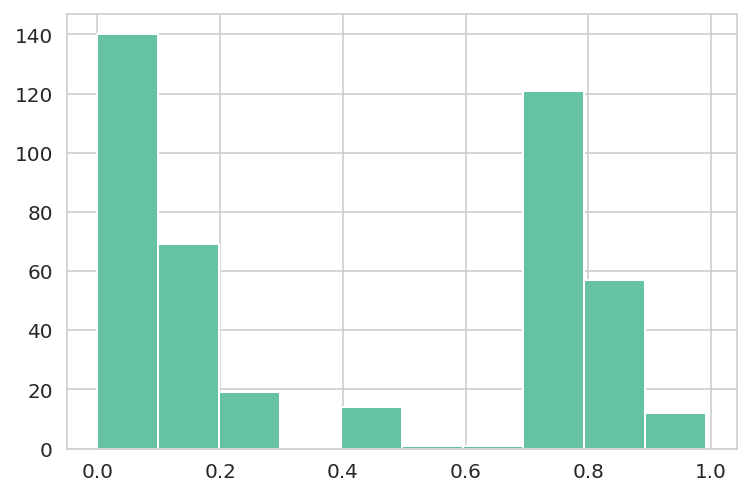

In [45]:
null_perc = (train.isnull().sum()/len(train)).sort_values(ascending=False)
null_perc.hist()

Distinct blocks of features with one block having the least amount, one block with around 50% nulls and the last block with over 80% nulls.

### Feature names

**Feature information**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr1, addr2: address
- dist1, dist2: distance
- (P_) and (R_) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

### Null value blocks

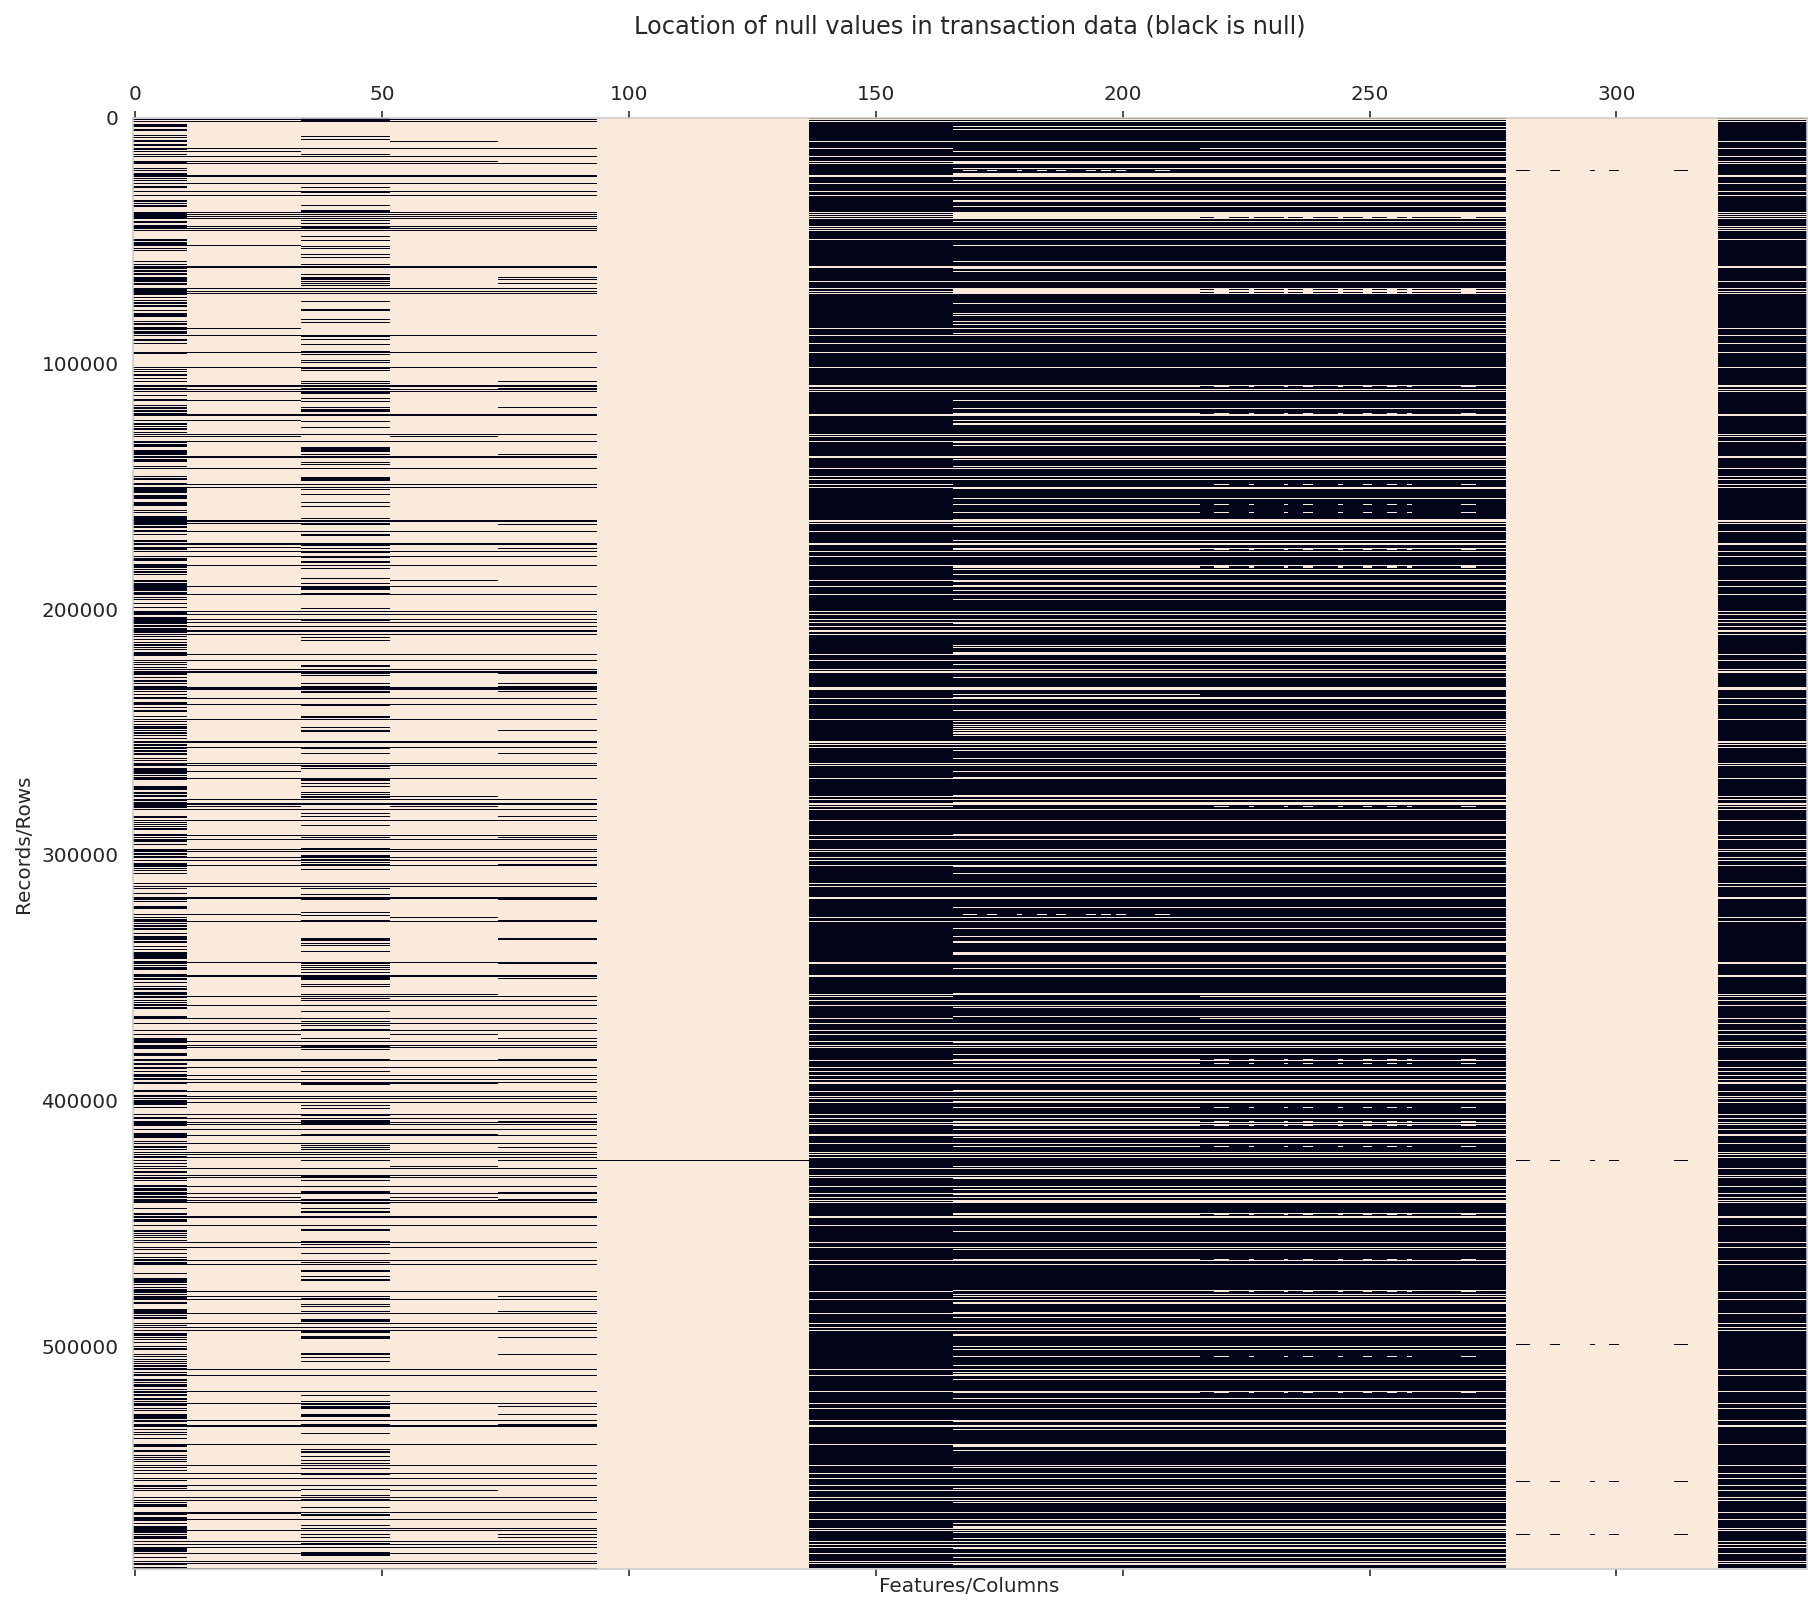

In [76]:
plt.figure(figsize=(15,13))
plt.matshow((~train[v_cols].isnull()).astype(int), fignum=1)
ax = plt.gca()
ax.set_aspect('auto')
ax.set_title('Location of null values in transaction data (black is null)')
ax.set_xlabel('Features/Columns')
ax.set_ylabel('Records/Rows')
plt.grid(False)
plt.show()

### Fraud percentage across products

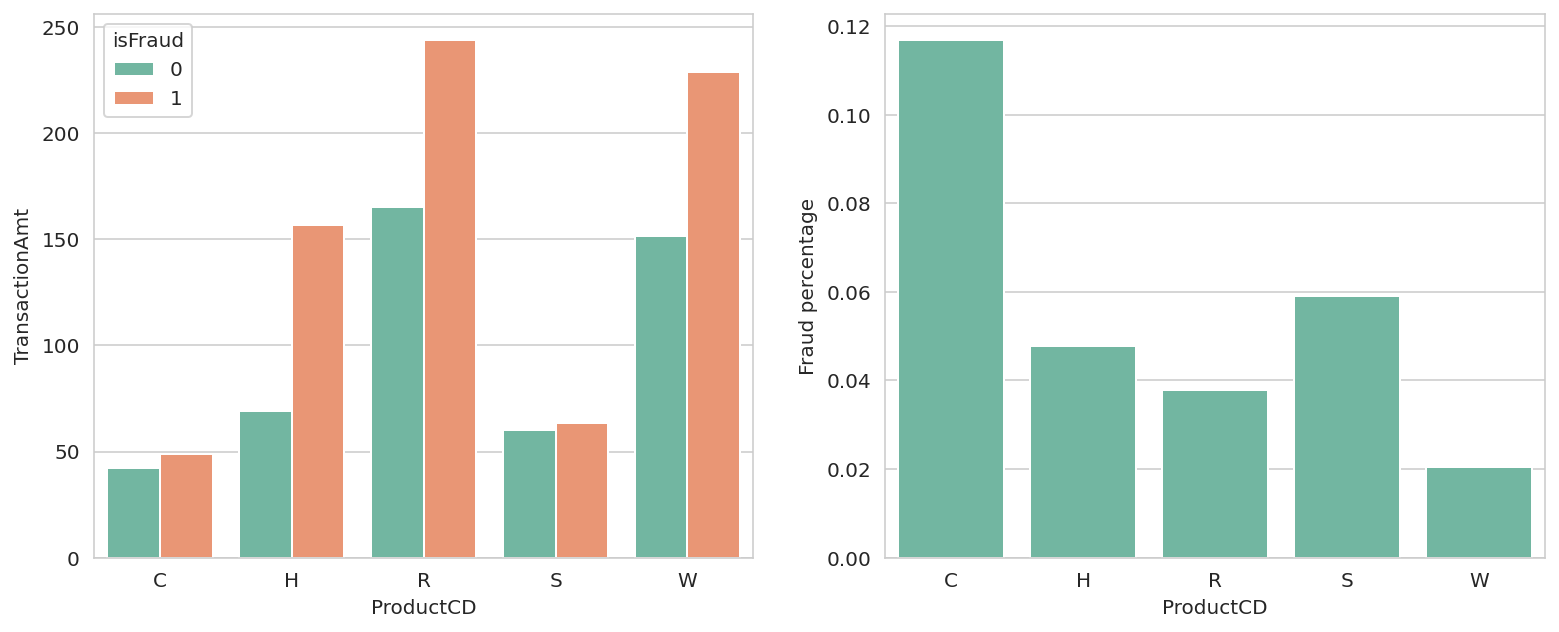

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

t = (
    train
    .groupby(by=['ProductCD', 'isFraud'])
    .agg({
        'TransactionID': 'count', 
        'TransactionAmt': 'mean'
    })
    .reset_index()
    .assign(TransactionID = lambda x: x['TransactionID']/x.groupby(by='ProductCD')['TransactionID'].transform(sum))
    .rename(columns={'TransactionID': 'Fraud percentage'})

)

sns.barplot(data=t, x='ProductCD', y='TransactionAmt', hue='isFraud', ax=ax[0])
sns.barplot(data=t[t['isFraud'] == 1], x='ProductCD', y='Fraud percentage', ax=ax[1], color=sns.color_palette()[0])

# plt.title('Transaction amount for each product split by fraud status')

### Null percentage across product split by fraud status

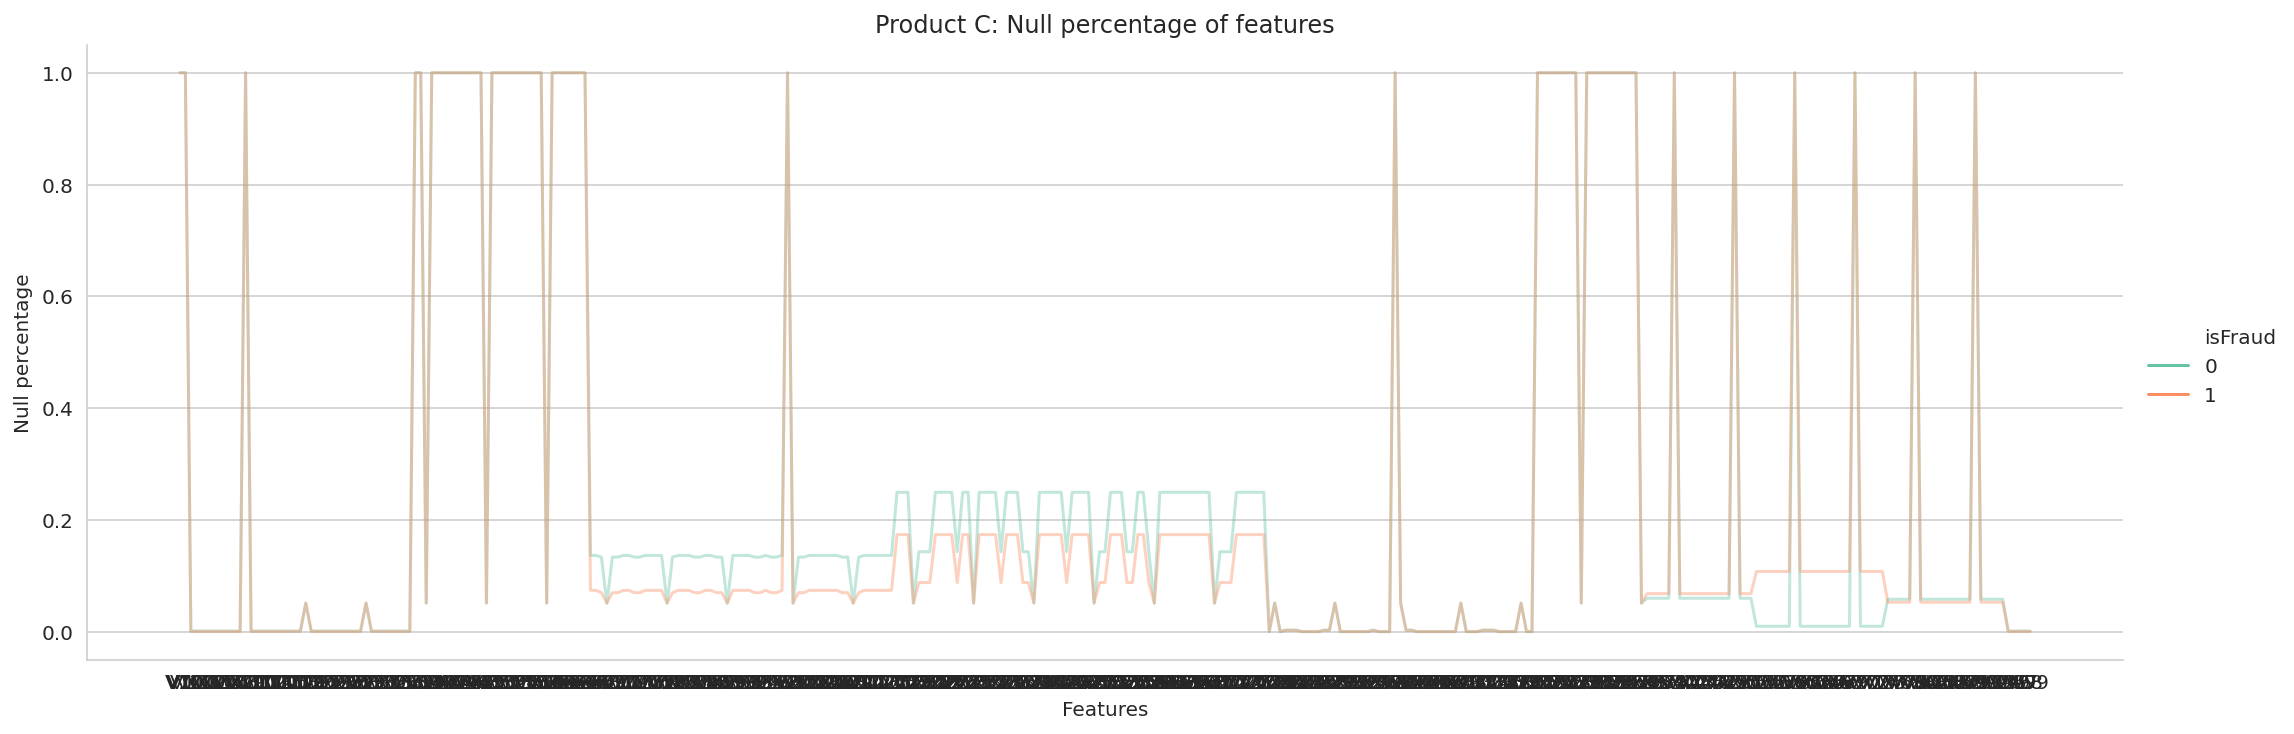

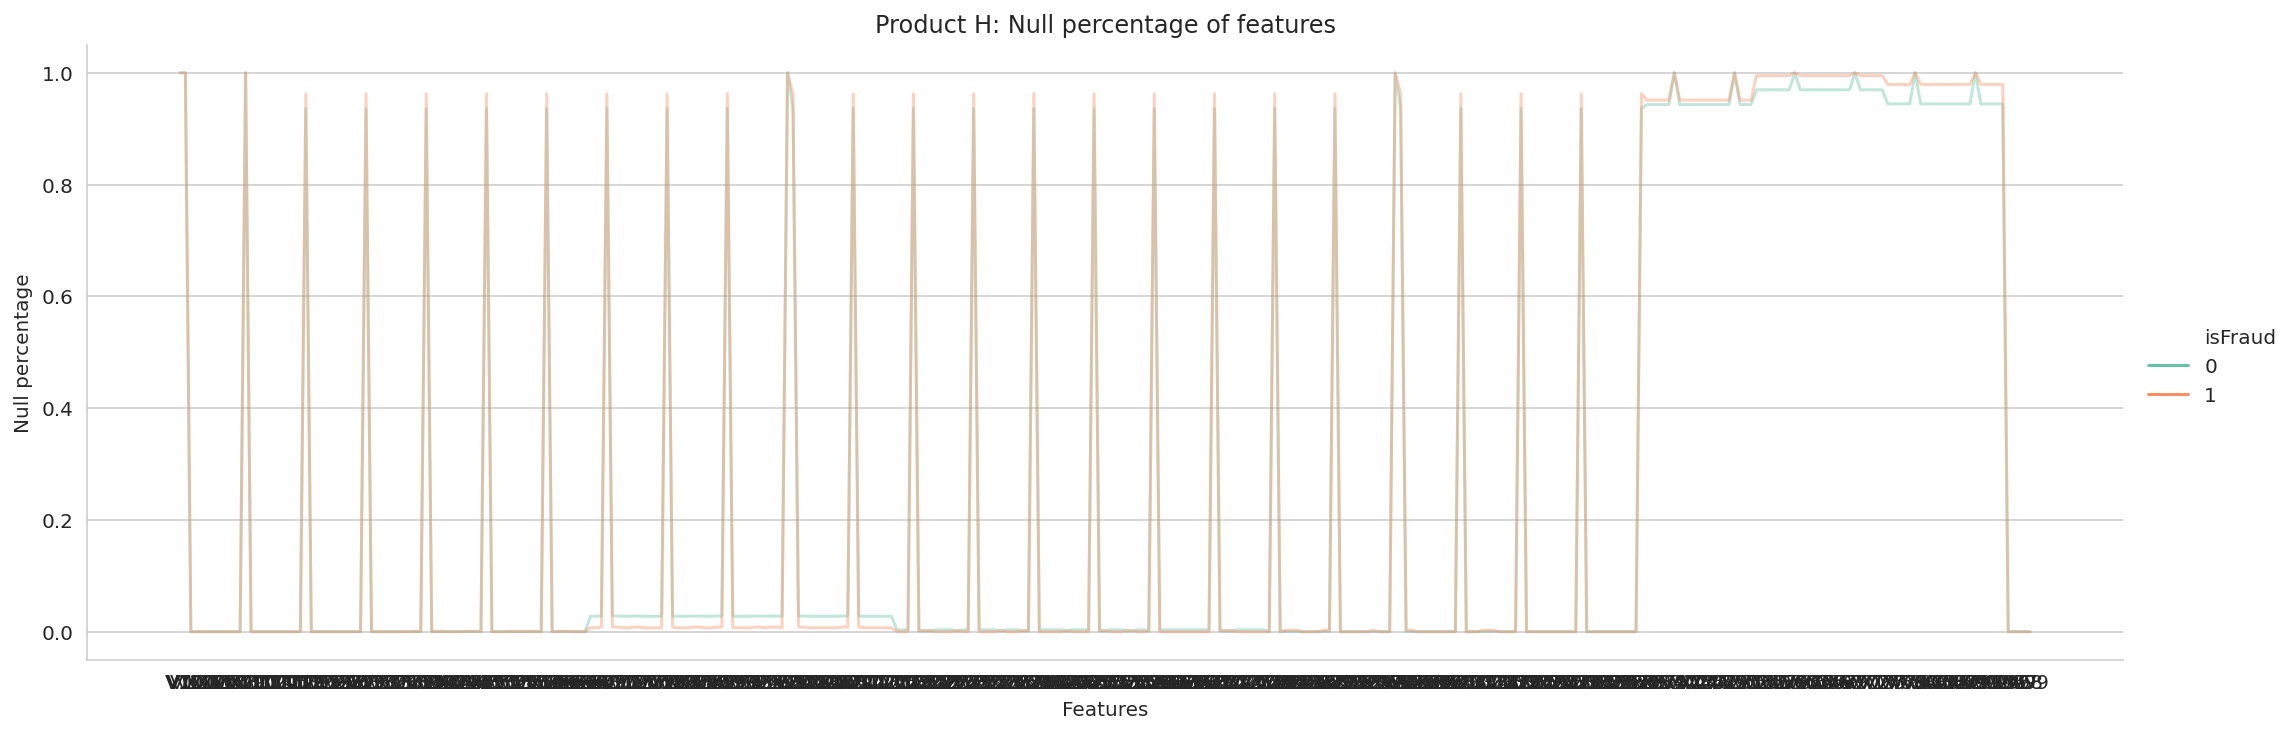

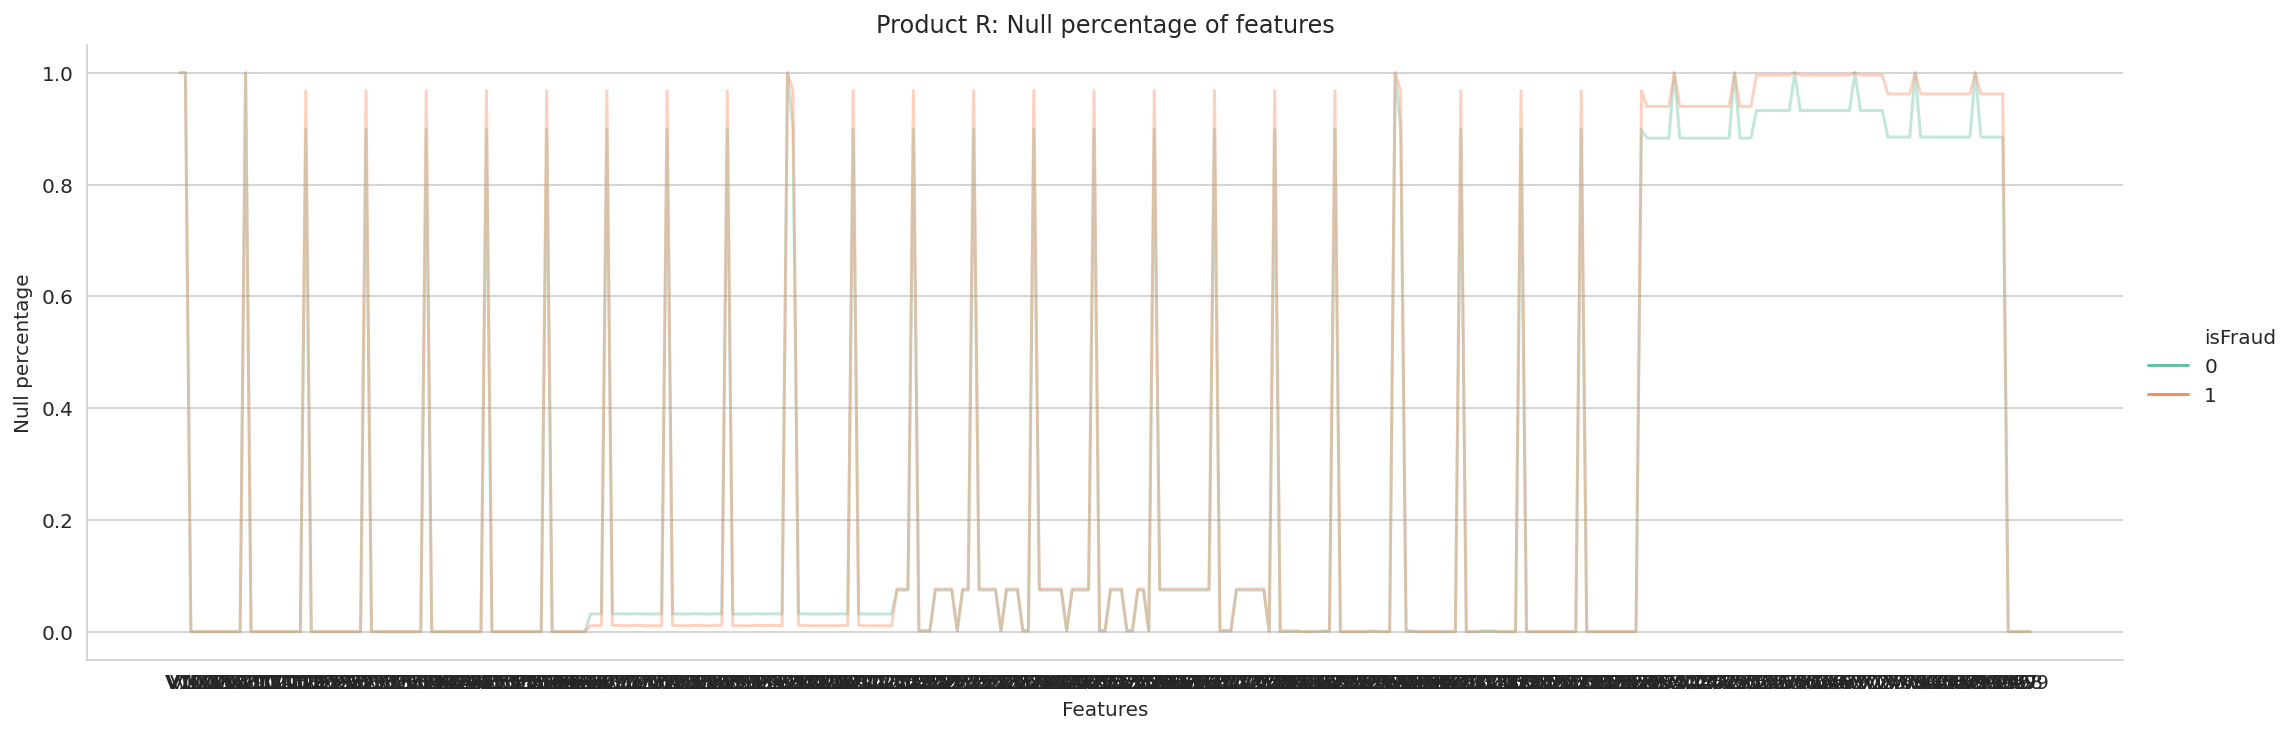

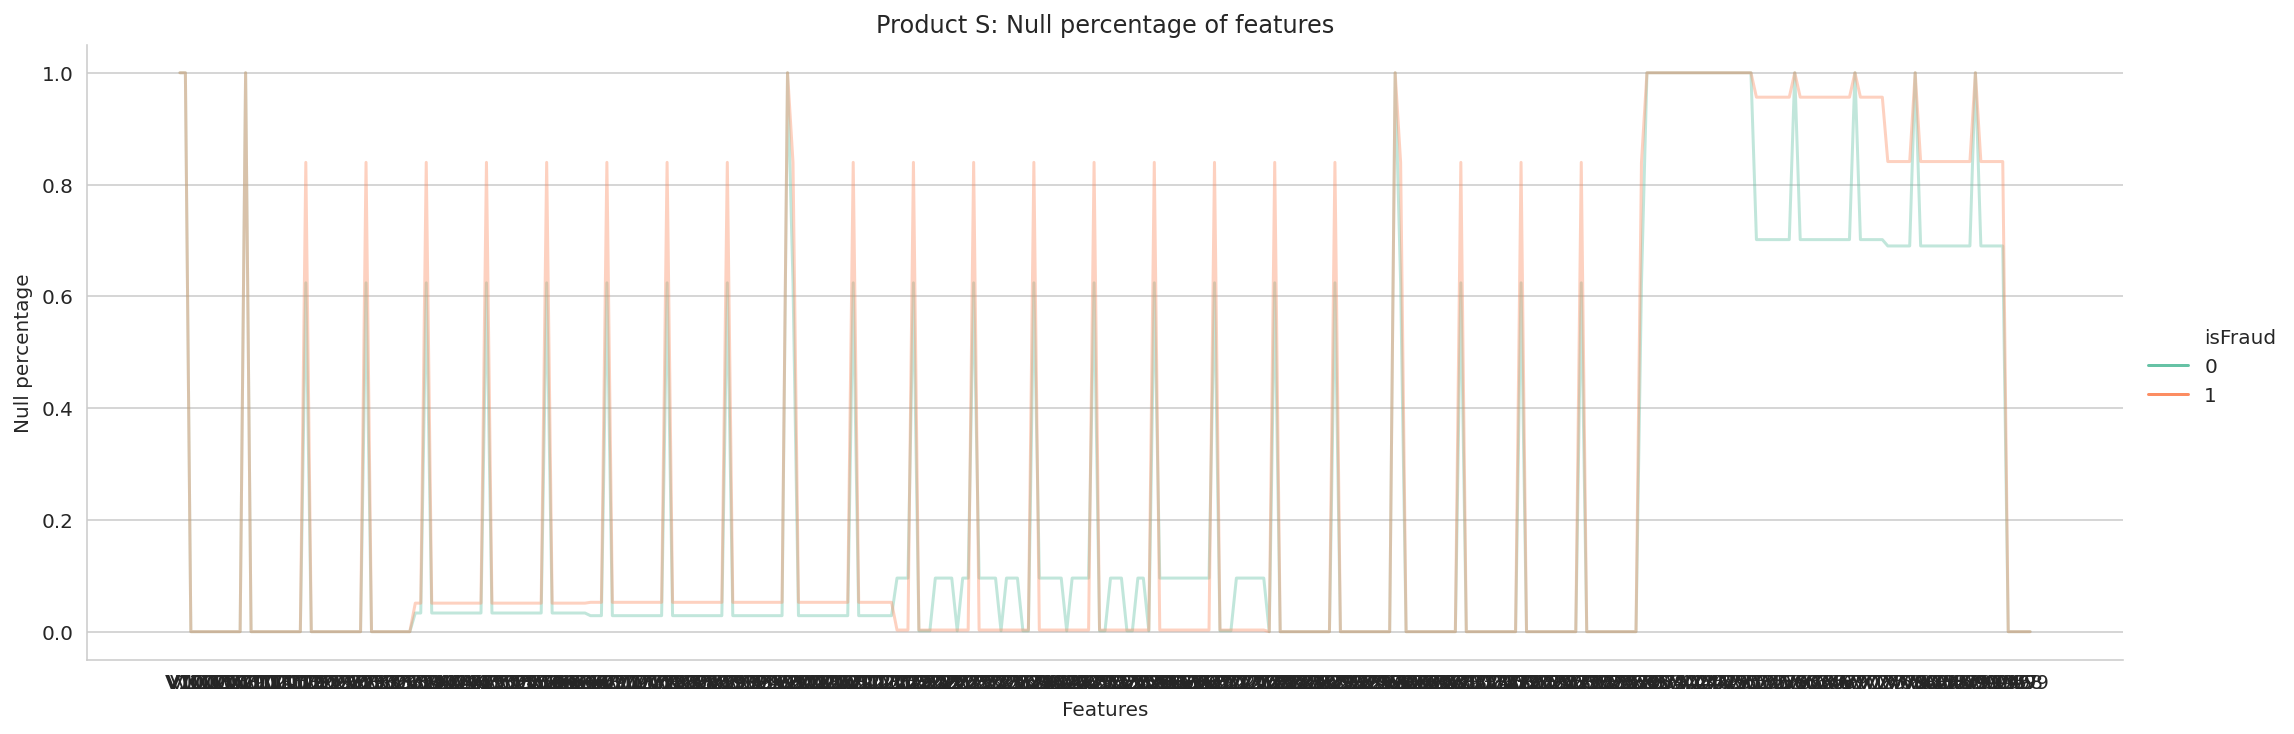

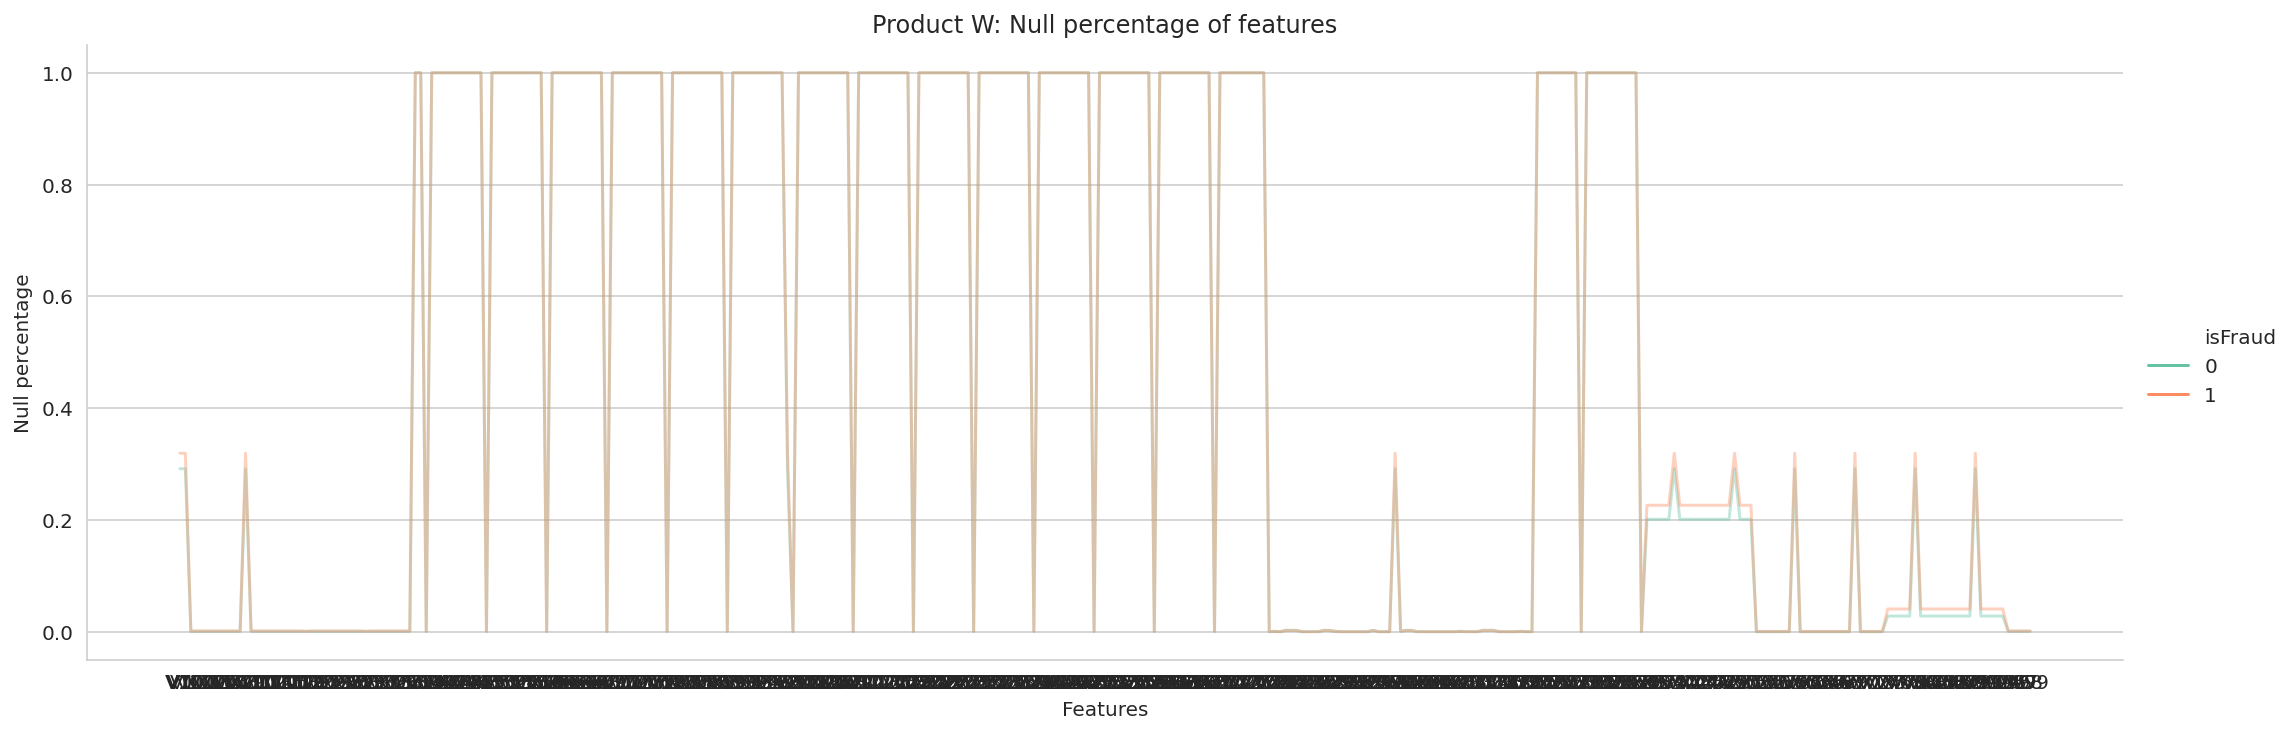

In [78]:
# coltypes = [dist_cols, mix_cols, card_cols, addr_cols, email_cols, c_cols, d_cols, m_cols, v_cols]
typecol = coltypes[8]

t = (
    train
    .set_index(['ProductCD', 'isFraud'])
    [typecol]
    .isnull()
    .reset_index()
    .groupby(by=['ProductCD', 'isFraud'])
    .mean()
    .reset_index()
    .melt(id_vars=['ProductCD', 'isFraud'], value_vars=typecol, var_name='Features', value_name='Null percentage')
    .assign(feature_type = lambda x: x['Features'])
)


for i, product in enumerate(products):
    sns.relplot(data=t[t['ProductCD'] == product], x='Features', y='Null percentage', hue='isFraud', aspect=3, kind='line', alpha=0.4)
    plt.grid(False, axis='x')
    plt.title(f'Product {product}: Null percentage of features')
#     break

We observe that null percentage varies across fraud status, thus there is some information in the null presence which can be learnt. Hence we need to choose a modelling approach which can handle null values by design.

In [13]:
train_t['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

---------

# Approach

**Preprocessing approaches**
- Sample cases such that all fraud cases are covered and the class imbalance is lessened (20k fraud, 80k legit)
- Remove high null ratio features
- For each product, remove set of features with high null ratio (these features can be different across products)

**Modelling approaches**
- 5 different models for 5 products in the data
- Xgboost, LightGBM algorithms since they natively handle null values

**Final approach**
- Split the data by Products since they show quite independent distributions in null values, suggesting that each product is independent from others to a high degree.
- Use XGBoost to train a binary classifier for each product and Grid Search for hyperparameters
- Combine the product specific trained classifier into a single classifier function for training and predicting
- [Optional] Make a single Linear Regression baseline model which trains on all of the products for comparison
- Performance measurement by F1 score, precision, recall and AUROC

------------

### Steps
- Define final features from coltypes
- Grid Search training function wrapping xgb
- Test run with sample data
- Full run and save trained models
- Predict
- Output graphs

### Define final features

In [68]:
label_col = 'isFraud'
transaction_cols = ['TransactionAmt']

features = []
features += transaction_cols
features += dist_cols
features += card_cols
features += addr_cols
features += email_cols
features += c_cols + d_cols + m_cols + v_cols
features += id_cols
features += device_cols
print(f'Total columns: {len(all_cols)}\nTotal features: {len(features)}')

Total columns: 434
Total features: 430


### Set up grid search on xgb

In [90]:
def fit_xgb(train, feature_cols, label_col, data_frac=1, xgb_threads=6, gridcv_threads=4):
    
    xgb = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=xgb_threads,
        scale_pos_weight=1,
        seed=42,
        verbosity=1
    )
    
    param_grid = {
        'learning_rate': [0.001, 0.01, 0.1],
        'n_estimators': [500, 1000, 2000, 5000],
#         'max_depth': [3, 5, 7],
#         'min_child_weight': [1, 3, 5],
#         'gamma': [0, 0.1, 0.2],
#         'subsample': [0.7, 0.85, 1],
#         'colsample_bytree': [0.7, 0.85, 1]
    }
    
    c = 1
    for ft in param_grid:
        c *= len(param_grid[ft])
    
    print(f'Parameter combinations: {c}')
    print(f'Total threads:{xgb_threads * gridcv_threads}/32')
    
    gsearch = GridSearchCV(
        estimator=xgb,
        param_grid=tmp_param_grid,
        scoring='roc_auc',
        n_jobs=gridcv_threads,
        cv=5,
        verbose=2
    )
    
    fit_train = train.sample(frac=data_frac, random_state=42)
    gsearch.fit(fit_train[feature_cols], fit_train[label_col])
    return gsearch

In [92]:
%%time
gsearch = fit_xgb(train, features, label_col, data_frac=0.1)

Parameter combinations: 12
Total threads:24/32
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.2min finished


CPU times: user 6min 35s, sys: 1.73 s, total: 6min 37s
Wall time: 3min 17s


In [93]:
mod = gsearch.best_estimator_

In [112]:
gsearch.score()

TypeError: score() missing 1 required positional argument: 'X'

In [111]:
'isFraud' in test.columns

False

In [110]:
pred = gsearch.predict(test[features])
metrics.roc_auc_score(test[label_col].values, pred)

KeyError: 'isFraud'

In [96]:
ftimp = pd.Series(mod.feature_importances_, index=features)

In [100]:
mod.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.001,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 500,
 'n_jobs': 6,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': 1,
 'nthread': 6,
 'seed': 42}

In [105]:
train[['C7', 'isFraud']].corr()

,C7,isFraud
C7,1.00000,0.02816
isFraud,0.02816,1.00000


In [98]:
ftimp.sort_values(ascending=False).head(50)

V201     0.077214
V258     0.064176
V257     0.048213
V244     0.024386
V242     0.018336
V187     0.017018
V45      0.014179
V246     0.014083
C7       0.012781
V156     0.011324
C12      0.011139
V225     0.011060
V200     0.010385
V103     0.010286
V318     0.010200
V295     0.009954
V268     0.009822
addr2    0.009519
V189     0.009434
id_17    0.009406
V317     0.009051
V308     0.008867
V154     0.008775
V134     0.008691
id_35    0.008423
C14      0.007738
C13      0.007602
V283     0.007203
V207     0.007181
C1       0.007168
V294     0.006895
C11      0.006774
D10      0.006655
C2       0.006227
dist1    0.005155
V53      0.005091
V313     0.005071
V102     0.004992
V281     0.004984
V54      0.004909
V266     0.004873
V315     0.004838
V133     0.004766
V194     0.004707
C10      0.004670
C4       0.004573
C8       0.004464
V243     0.004413
V152     0.004348
V19      0.004342
dtype: float32